Authors : Lucas Armada, Myriam Ghali, Josué Maechling, William Martin

In [45]:
# import standard libraries
import copy
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import third-party libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# import local libraries

# Load data


In [109]:
# load data from google colab (GOOGLE_COLAB = False)
# or load data locally (GOOGLE_COLAB = True)
GOOGLE_COLAB = False
    
if not GOOGLE_COLAB:
    df = pd.read_csv('customers.csv')

else:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/My Drive/ds/customers.csv')

# Data cleaning


In [110]:
# convert column TotalCharges to numeric as done in Problem Set 1
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df = df.dropna(axis = 0, how = 'any')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [111]:
#Target feature is "Churn"
# Data to plot
sizes = df['Churn'].value_counts(sort = True)
colors = ["grey","purple"] 

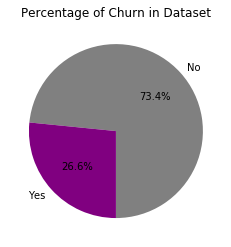

In [112]:
# Plot
plt.pie(sizes, colors=colors,autopct='%1.1f%%', labels = ['No', 'Yes'], shadow=False, startangle=270,)
plt.title('Percentage of Churn in Dataset')
plt.show()

In [113]:
churned = df['Churn'].value_counts()[1]
churned

1869

> Over a quarter of the clients (1869) have churned. We are interested to predict which client will churn in the future based on common features with the ones who have churned so far.

# Feature encoding


In [114]:
# set customerID to index since we are clearly not going to use this as a feature in our models
df = df.set_index('customerID')

# print possibe values for each categorical feature
for col in df:
    if df[col].dtype == 'object':
        print('{}: {}'.format(col, ', '.join(df[col].unique().tolist())))

# customers with no internet service
customers_nointernet = df[df['InternetService'] == 'No'].index

gender: Female, Male
Partner: Yes, No
Dependents: No, Yes
PhoneService: No, Yes
MultipleLines: No phone service, No, Yes
InternetService: DSL, Fiber optic, No
OnlineSecurity: No, Yes, No internet service
OnlineBackup: Yes, No, No internet service
DeviceProtection: No, Yes, No internet service
TechSupport: No, Yes, No internet service
StreamingTV: No, Yes, No internet service
StreamingMovies: No, Yes, No internet service
Contract: Month-to-month, One year, Two year
PaperlessBilling: Yes, No
PaymentMethod: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)
Churn: No, Yes


In [115]:
# check features of customers which have any value == 'No internet services' are the same customers where
# InternetService == 'No'
for col in df:
    if 'No internet service' in df[col].unique().tolist():
        error = customers_nointernet.difference(df[df[col] == 'No internet service'].index)
        assert error.empty # no assert error = good news

# create new column internet with binary values 1 yes, 0 no
df['Internet'] = df['InternetService'].apply(lambda x: 0 if x == 'No' else 1)
# same for DSL / Fiber optic
df['DSL'] = df['InternetService'].apply(lambda x: 1 if x == 'DSL' else 0)
df['FiberOptic'] = df['InternetService'].apply(lambda x: 1 if x == 'Fiber optic' else 0)
# drop useless columns
df = df.drop(columns = 'InternetService')


In [116]:
# replace features with only two possible values with binary value. We know that if the customer has no 
# internet service then the customer will not have the service feature. The same goes for multiple lines.
binary_map = {'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0, 'Female': 0, 'Male': 1}
replace_dict = {'gender': binary_map,
                'Partner': binary_map,
                'Dependents': binary_map,
                'PhoneService': binary_map,
                'OnlineSecurity': binary_map,
                'OnlineBackup': binary_map,
                'DeviceProtection': binary_map,
                'TechSupport': binary_map,
                'StreamingTV': binary_map,
                'StreamingMovies': binary_map,
                'PaperlessBilling': binary_map,
                'Churn': binary_map,
                'MultipleLines': binary_map}
df = df.replace(replace_dict, inplace = False)
df = df.rename(columns = {'gender': 'Male'})

In [117]:
# still need to encode contract and payment method features, we use one hot encoding
dummies = pd.get_dummies(df[['Contract', 'PaymentMethod']], prefix = ['Contract',  'Payment'], prefix_sep = '=')
df = pd.concat([df, dummies], axis = 1)
df = df.drop(columns = ['Contract', 'PaymentMethod'])

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(int)

In [118]:
# Finished encoding, all dtypes are either int or float
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Male                               7032 non-null   int64  
 1   SeniorCitizen                      7032 non-null   int64  
 2   Partner                            7032 non-null   int64  
 3   Dependents                         7032 non-null   int64  
 4   tenure                             7032 non-null   int64  
 5   PhoneService                       7032 non-null   int64  
 6   MultipleLines                      7032 non-null   int64  
 7   OnlineSecurity                     7032 non-null   int64  
 8   OnlineBackup                       7032 non-null   int64  
 9   DeviceProtection                   7032 non-null   int64  
 10  TechSupport                        7032 non-null   int64  
 11  StreamingTV                        7032 non-nu

# Feature selection


> Features selection allows us to choose the most relevant criterias to determine if a client will churn or not, while discarding any criterias that could lead us to a wrong prediction

In [119]:
# separate exo/indogenoeous variables
X, y = df.drop(columns = 'Churn'), df[['Churn']]
X_norm = preprocessing.MinMaxScaler().fit_transform(X)

## Recursive selection


In [120]:
#Allows us to determine the optimal number of features to select for perdiction
selector_rfe = RFECV(estimator = SVC(kernel = 'linear'), cv = StratifiedKFold(10), step = 1)
selector_rfe = selector_rfe.fit(X_norm, y)

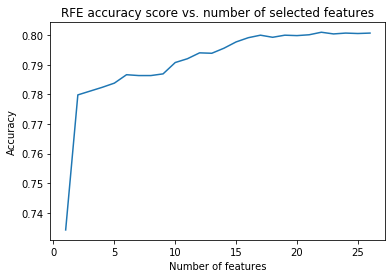

In [121]:
#Show RFE results 
plt.plot(np.arange(1,27), selector_rfe.grid_scores_)
plt.title('RFE accuracy score vs. number of selected features')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.show()

In [122]:
optimal_number = np.argmax(selector_rfe.grid_scores_)
max_accuracy = selector_rfe.grid_scores_[optimal_number]
mask_rfe = selector_rfe.support_

In [123]:
#num_feats = optimal_number, number of best features to choose from each algorithm below
num_feats = 7
# get 'num_feats' best rfe features
rfe_feature = X.loc[:,mask_rfe].columns.tolist()

## SelectKBest


In [124]:
# use the selet k best method from sklearn and evaluate with the chi squared function
selector_kbest = SelectKBest(score_func = chi2, k = 'all')
selector_kbest.fit(X_norm, y)
mask_kbest = selector_kbest.get_support()
features_kbest = pd.Series(data = selector_kbest.scores_, index = X.columns)
features_kbest_sorted = features_kbest.sort_values(ascending = False)

chi_feature = features_kbest_sorted.index[:num_feats].tolist()

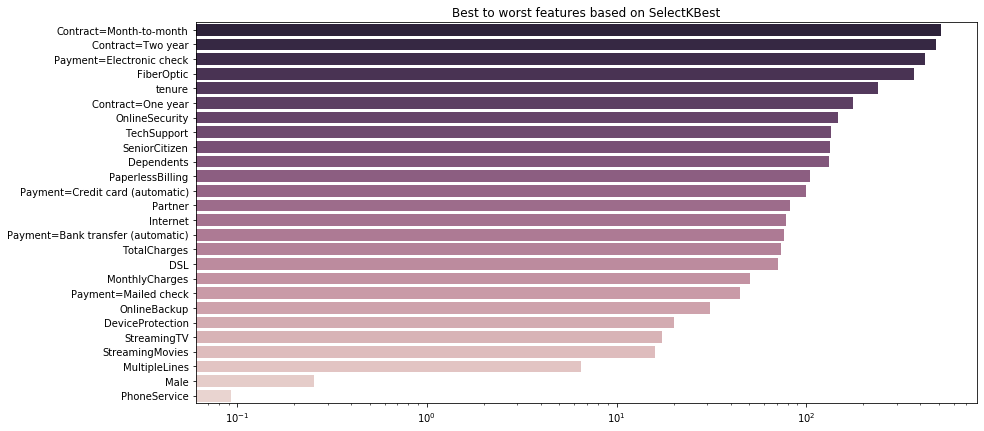

In [125]:
# show features from best to worst
fig, ax = plt.subplots(figsize = (14, 7))
_ = sns.barplot(y = features_kbest_sorted.index, x = features_kbest_sorted.values, orient = 'h', ax = ax,
                palette = sns.cubehelix_palette(len(features_kbest), reverse = True))
ax.set_xscale("log")
ax.set_title('Best to worst features based on SelectKBest')
plt.show()


## ExtraTreesClassifier

In [127]:
# use the extra trees classifire from sklearn
common = 2 #we think that common% of the people who have churned must be in the sample to do deeper in the node of the tree
min_samples_leaf = int(common * churned / 100)
selector_trees_gini = ExtraTreesClassifier(criterion = 'gini', min_samples_leaf = min_samples_leaf)
selector_trees_gini.fit(X, y)
features_trees_gini = pd.Series(data = selector_trees_gini.feature_importances_, index = X.columns)
features_trees_sorted_gini = features_trees_gini.sort_values(ascending = False)

trees_feature_gini = features_trees_sorted_gini.index[:num_feats].tolist()

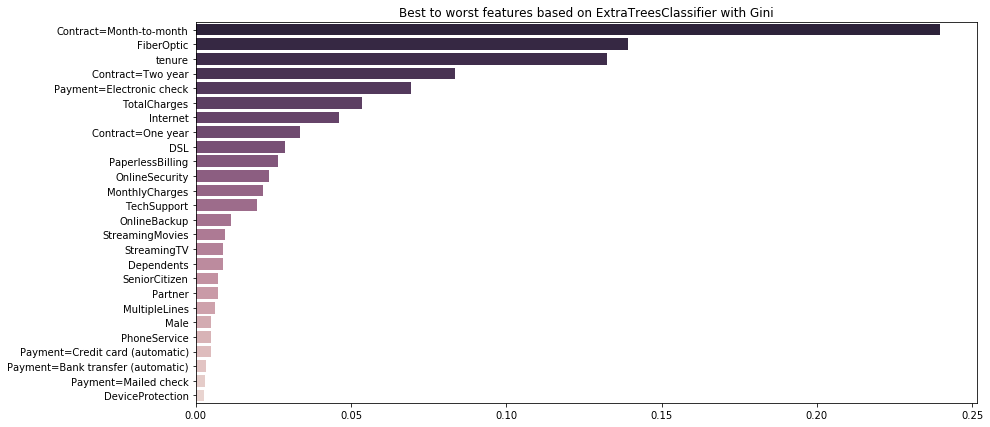

In [128]:
# show features from best to worst
fig, ax = plt.subplots(figsize = (14, 7))
_ = sns.barplot(y = features_trees_sorted_gini.index, x = features_trees_sorted_gini.values, orient = 'h', ax = ax,
                palette = sns.cubehelix_palette(len(features_trees_gini), reverse = True))
ax.set_title('Best to worst features based on ExtraTreesClassifier with Gini')
plt.show()

In [129]:
# use the extra trees classifire from sklearn
selector_trees_entropy = ExtraTreesClassifier(criterion = 'entropy', min_samples_leaf = min_samples_leaf)
selector_trees_entropy.fit(X, y)
features_trees_entropy = pd.Series(data = selector_trees_entropy.feature_importances_, index = X.columns)
features_trees_sorted_entropy = features_trees_entropy.sort_values(ascending = False)

trees_feature_entropy = features_trees_sorted_entropy.index[:num_feats].tolist()

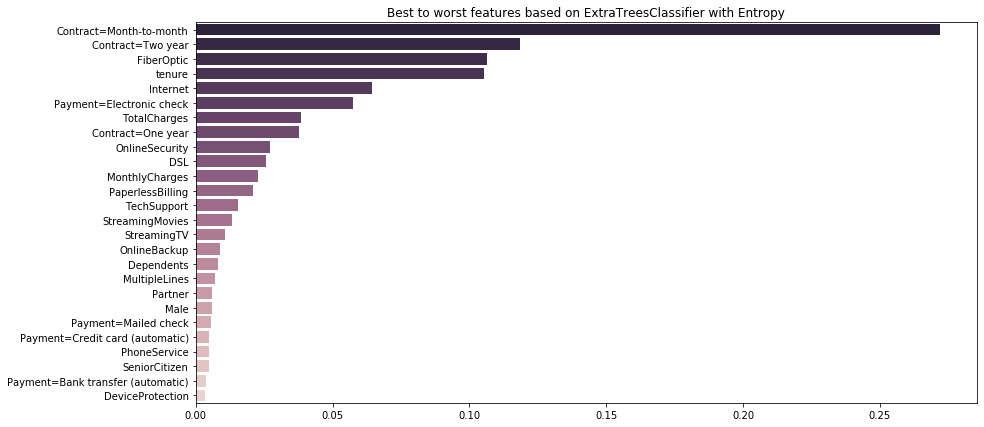

In [130]:
# show features from best to worst
fig, ax = plt.subplots(figsize = (14, 7))
_ = sns.barplot(y = features_trees_sorted_entropy.index, x = features_trees_sorted_entropy.values, orient = 'h', ax = ax,
                palette = sns.cubehelix_palette(len(features_trees_entropy), reverse = True))
ax.set_title('Best to worst features based on ExtraTreesClassifier with Entropy')
plt.show()

## Pearson correlation selection

In [173]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns:
        cor = np.corrcoef(X[i], y.iloc[:,0])[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature, cor_list

cor_support, cor_feature, cor_list = cor_selector(X, y, num_feats)

In [134]:
# Intersection of best features from RFE, chi, trees (gini), trees (entropy) and pearson features
best_features_all = set(rfe_feature).intersection(set(chi_feature))\
                    .intersection(set(trees_feature_gini))\
                    .intersection(set(trees_feature_entropy))\
                    .intersection(set(cor_feature))
best_features_all = list(best_features_all)
print('Best features from intersection: {}'.format(', '.join(best_features_all)))

Best features from intersection: Contract=Month-to-month, Contract=Two year, FiberOptic, Payment=Electronic check, tenure


In [156]:
# Correlation matrix among all features
corr_matrix_kendall = df.corr('kendall')
corr_matrix_pearson = df.corr()

# fitler to target of intersest
corr_matrix_kendall = corr_matrix_kendall[['Churn']].transpose()
corr_matrix_pearson = corr_matrix_pearson[['Churn']].transpose()


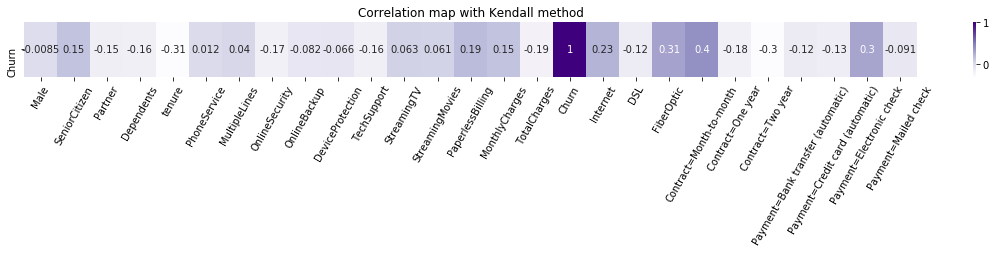

In [160]:
# plot heatmap of correelation matrix
fig, ax = plt.subplots(figsize = (20, 1))
ax = sns.heatmap(corr_matrix_kendall, annot = True, cmap = 'Purples')
plt.xticks(rotation = 60)
plt.title('Correlation map with Kendall method')
plt.show()

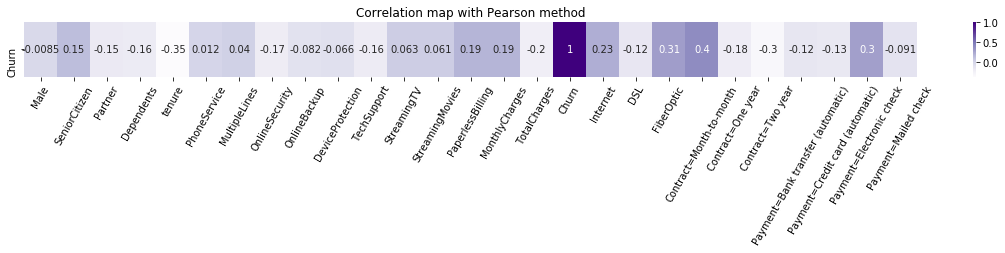

In [162]:
# plot heatmap of correelation matrix
fig, ax = plt.subplots(figsize = (20, 1))
ax = sns.heatmap(corr_matrix_pearson, annot = True, cmap = 'Purples')
plt.xticks(rotation = 60)
plt.title('Correlation map with Pearson method')
plt.show()

# Predicting churn

## Scaling the data

In [163]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0, 1)) # reasonable since most categorial variables are either 0 or 1
min_max_scaler = min_max_scaler.fit(df)
df_min_max = min_max_scaler.transform(df)
df_min_max = pd.DataFrame(data = df_min_max, columns = df.columns, index = df.index)
CV = 7 #choose constant for all methods 

## K-Neighbors classifier

In [164]:
# define grid parameters to use for gridsearch
param_grid_kneigh = {'weights': ['uniform', 'distance'], 
                       'metric': ['euclidean', 'minkowski'], 
                       'n_neighbors': [2,3,5,7,11,17,23]
                    }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation as well
classifier_kneigh = GridSearchCV(KNeighborsClassifier(algorithm = 'auto'),
                                scoring = 'accuracy',
                                param_grid = param_grid_kneigh,
                                cv = CV
                                )

## Random Tree

In [166]:
# define grid parameters to use for gridsearch
param_grid_trees = {'max_depth': [1, 5, 10, 50, 100, 200, 500],
                    'min_samples_split': [2, 4, 8, 16],
                    'min_samples_leaf': [1, 5, 10, 50, 100, 200],
                    }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation as well
classifier_trees = GridSearchCV(DecisionTreeClassifier(),
                                param_grid = param_grid_trees,
                                scoring = 'accuracy',
                                cv = CV
                                )

## Random Forest

In [167]:
# define grid parameters to use for gridsearch
param_grid_forest = {'n_estimators': [3,5,10,50,100,150,200],
                     'max_depth': [1, 5, 10, 50],
                     'min_samples_split': [2, 4, 8],
                     'min_samples_leaf': [10, 50, 100, 200],
                     }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation
classifier_forest = GridSearchCV(RandomForestClassifier(),
                                 param_grid = param_grid_forest,
                                 scoring = 'accuracy',
                                 cv = CV
                                 )

## Support Vector Machine 

In [168]:
# define grid parameters to use for gridsearch
param_grid_svc = {'C': [1, 10, 100, 1000], 
                  'gamma': [0.1, 0.01, 0.001, 0.0001],
                 }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation as well
classifier_svc = GridSearchCV(SVC(kernel = 'rbf'),
                              param_grid = param_grid_svc,
                              scoring = 'accuracy',
                              cv = CV
                              )

## Split train/test set

In [169]:
X_best_all = df_min_max[best_features_all]

X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best_all, y, test_size = 0.2)

X_train_forest_best, \
X_test_forest_best, \
y_train_forest_best, \
y_test_forest_best = train_test_split(df[best_features_all], y, test_size = 0.2)

# fit models 
classifier_kneigh.fit(X_train_best, y_train_best)
classifier_trees.fit(X_train_best, y_train_best)
classifier_forest.fit(X_train_forest_best, y_train_forest_best)
classifier_svc.fit(X_train_best, y_train_best)

GridSearchCV(cv=7, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.1, 0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [178]:
best_score = {
    'K-Neigh': classifier_kneigh.score(X_test_best, y_test_best),
    'Trees': classifier_trees.score(X_test_best, y_test_best),
    'Forest': classifier_forest.score(X_test_forest_best, y_test_forest_best),
    'SVC': classifier_svc.score(X_test_best, y_test_best)
    }
best_score = pd.Series(best_score)

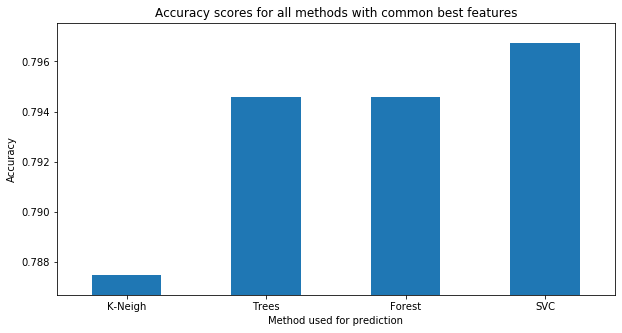

In [191]:
# plot best scores
fig, ax = plt.subplots(figsize = (10, 5))
best_score.plot.bar(title = 'Accuracy scores for all methods with common best features', rot = 0)
_ = ax.set_ylabel('Accuracy')
_ = ax.set_xlabel('Method used for prediction')
_ = ax.set_ylim([best_score.min()*0.999, best_score.max()*1.001])

In [203]:
# Iterate over x best features and train each model individually (RUN_HEAVY = True)
# read results directly from pickle files (RUN_HEAVY = False)
RUN_HEAVY = False

if RUN_HEAVY:

    score_trees = []
    score_forest = []
    score_svc = []
    score_kneigh = []

    #test for all methods 
    min_feature
    i = 3
    
    while i < 11: 
        # selection from algorithm
        selected_features_kbest = features_kbest_sorted.index[0:i]
        selected_features_gini = features_trees_sorted_gini.index[0:i]
        selected_features_entropy = features_trees_sorted_entropy.index[0:i]

        features = [selected_features_kbest, selected_features_gini, selected_features_entropy, cor_feature]
        
        for f in features: 
            X_feat_min_max = df_min_max[f]
            X_train, X_test, y_train, y_test = train_test_split(X_feat_min_max, y, test_size = 0.2)
            X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(df[f], y, test_size = 0.2)

            classifier_kneigh.fit(X_train, y_train) 
            classifier_trees.fit(X_train, y_train)
            classifier_forest.fit(X_train_forest, y_train_forest)
            classifier_svc.fit(X_train, y_train)

            score_kneigh.append(classifier_kneigh.score(X_test, y_test))
            score_trees.append(classifier_trees.score(X_test, y_test))
            score_forest.append(classifier_forest.score(X_test_forest,y_test_forest))
            score_svc.append(classifier_svc.score(X_test, y_test))

        i = i + 1 
        
    with open('score_kneigh_3_10.pickle', 'wb') as f:
        pickle.dump(score_kneigh, f)
    
    with open('score_trees_3_10.pickle', 'wb') as f:
        pickle.dump(score_trees, f)
    
    with open('score_forest_3_10.pickle', 'wb') as f:
        pickle.dump(score_forest, f)
        
    with open('score_svc_3_10.pickle', 'wb') as f:
        pickle.dump(score_svc, f)

else: # read results directly from pickles files 
    
    with open('score_kneigh_3_10.pickle', 'rb') as f:
        score_kneigh = pickle.load(f)
        
    with open('score_trees_3_10.pickle', 'rb') as f:
        score_trees = pickle.load(f)
        
    with open('score_forest_3_10.pickle', 'rb') as f:
        score_forest = pickle.load(f)
        
    with open('score_svc_3_10.pickle', 'rb') as f:
        score_svc = pickle.load(f)
    

In [217]:
num_cols = 4
# put results in dataframe
df_score_kneigh = pd.DataFrame(data = np.resize(score_kneigh, (int(32/num_cols), num_cols)),
                              columns = ['K-best', 'Tree-Gini', 'Tree-Entropy', 'Pearson Correlation'],
                              index = list(range(3, 11))
                              )

df_score_trees = pd.DataFrame(data = np.resize(score_trees, (int(32/num_cols), num_cols)),
                             columns = ['K-best', 'Tree-Gini', 'Tree-Entropy', 'Pearson Correlation'],
                             index = list(range(3, 11))
                             )

df_score_forest = pd.DataFrame(data = np.resize(score_forest, (int(32/num_cols), num_cols)),
                              columns = ['K-best', 'Tree-Gini', 'Tree-Entropy', 'Pearson Correlation'],
                              index = list(range(3, 11))
                              )

df_score_svc = pd.DataFrame(data = np.resize(score_svc, (int(32/num_cols), num_cols)),
                           columns = ['K-best', 'Tree-Gini', 'Tree-Entropy', 'Pearson Correlation'],
                           index = list(range(3, 11))
                           )

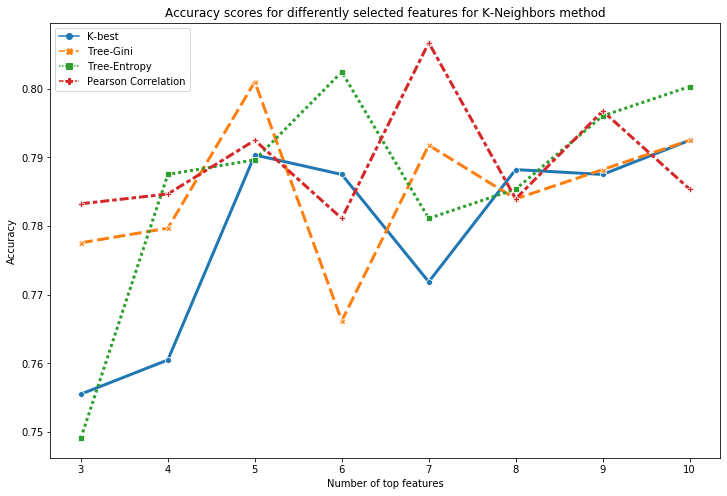

In [236]:
# Plot results for k neighbours algorithm
fig, ax = plt.subplots(figsize = (12, 8))
_ = sns.lineplot(data = df_score_kneigh, markers = True, linewidth = 3)
_ = ax.set_xlabel('Number of top features')
_ = ax.set_ylabel('Accuracy')
_ = ax.set_title('Accuracy scores for differently selected features for K-Neighbors method')

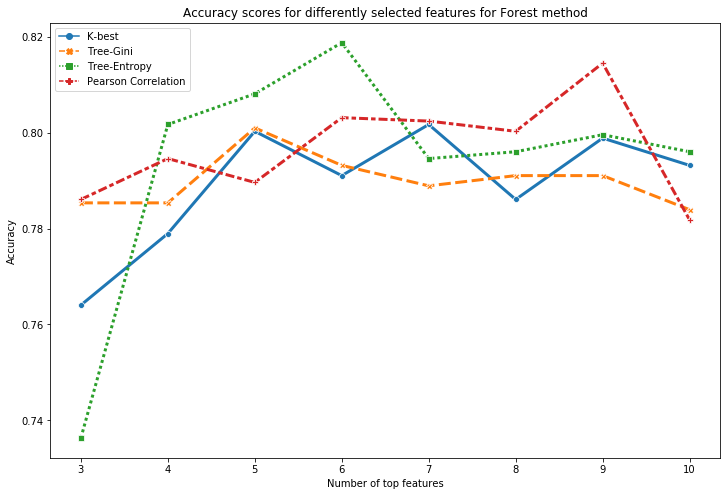

In [237]:
# Plot results for forest algorithm
fig, ax = plt.subplots(figsize = (12, 8))
_ = sns.lineplot(data = df_score_forest, markers = True, linewidth = 3)
_ = ax.set_xlabel('Number of top features')
_ = ax.set_ylabel('Accuracy')
_ = ax.set_title('Accuracy scores for differently selected features for Forest method')

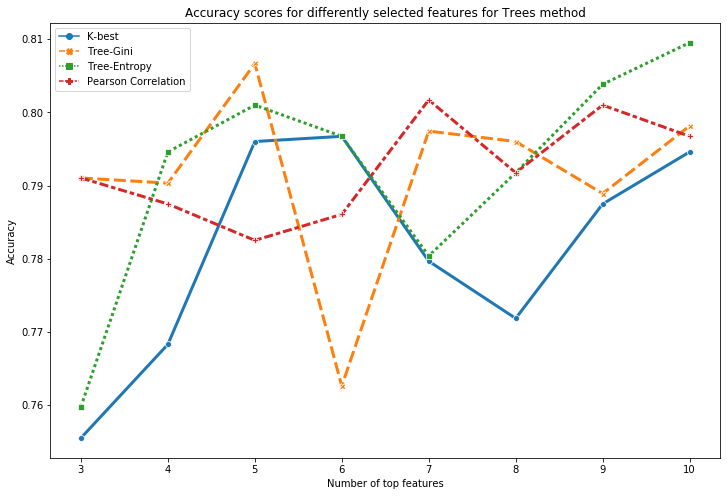

In [238]:
# Plot results for trees algorithm
fig, ax = plt.subplots(figsize = (12, 8))
_ = sns.lineplot(data = df_score_trees, markers = True, linewidth = 3)
_ = ax.set_xlabel('Number of top features')
_ = ax.set_ylabel('Accuracy')
_ = ax.set_title('Accuracy scores for differently selected features for Trees method')

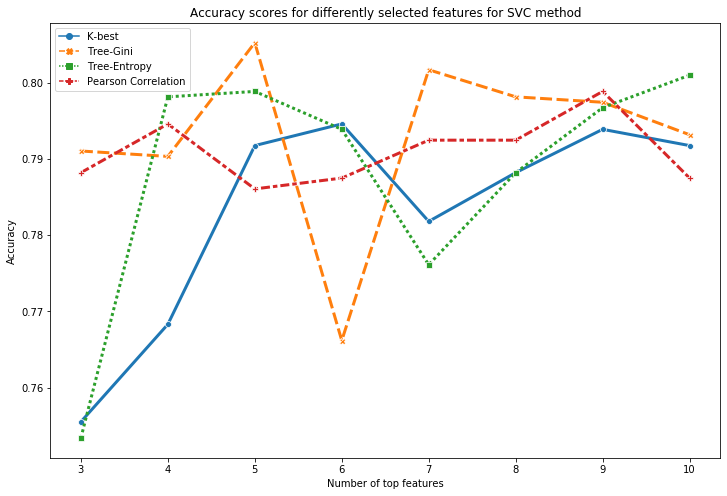

In [239]:
# Plot results for SVC algorithm
fig, ax = plt.subplots(figsize = (12, 8))
_ = sns.lineplot(data = df_score_svc, markers = True, linewidth = 3)
_ = ax.set_xlabel('Number of top features')
_ = ax.set_ylabel('Accuracy')
_ = ax.set_title('Accuracy scores for differently selected features for SVC method')

In [297]:
# compute maximum score across all scores
all_scores = pd.concat([df_score_kneigh, df_score_forest, df_score_trees, df_score_svc], axis = 1,
                      keys = ['K-Neighbors', 'Random forest', 'Random trees', 'SVM'])

In [306]:
max_score_algo = all_scores.max(axis = 0).idxmax(axis = 1)
max_score_num = all_scores.max(axis = 1).idxmax(axis = 1)
max_score = all_scores.max().max()

print('Best algorithm: \nClassifier: {}\nFeature selector: {}\nNumber of selected best features: {}\nScore: {:.2f}%'.\
      format(max_score_algo[0], max_score_algo[1], max_score_num, max_score*100))

Best algorithm: 
Classifier: Random forest
Feature selector: Tree-Entropy
Number of selected best features: 6
Score: 81.88%
